## Before/after calibration NDVI time-series for some regions

In the areas with the worst correlation between MODIS and AVHRR, plot the timeseries before and after calibration to demonstrate the improvements

## Libraries

In [1]:
import sys
import xarray as xr
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import contextily as ctx

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Analysis Parameters

In [2]:
model_var='NDVI'
crs='epsg:4326'
name='trees'

## Open data

In [3]:
base = '/g/data/os22/chad_tmp/AusENDVI/data/'

#open calibrated AVHRR
# merge = assign_crs(xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc'),
#                    crs=crs)['NDVI']

trees = xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_trees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_nontrees_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
desert = xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_desert_CLIM_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
merge = xr.where(np.isnan(trees), nontrees, trees)
merge = xr.where(np.isnan(desert), merge, desert)
merge = assign_crs(merge, crs=crs)
merge = merge.rename('NDVI')

#open original AVHRR
avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_NDVI_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)

#Open MODIS
modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)

#clip time lengths
# merge = merge.sel(time=slice('1982','2000-02'))
# avhrr = avhrr.sel(time=slice('1982','2000-02'))

#drop 2000 where the data is bad to need to fix in ML script
_2000 = merge.sel(time=slice('2000-03', '2001-01'))
_2000 = _2000.where(_2000<-1, np.nan)
times_to_drop = merge.time.sel(time=slice('2000-03', '2001-01'))
merge = merge.drop_sel(time=times_to_drop)
merge = xr.concat([merge, _2000], dim='time').sortby('time')

_2000 = avhrr.sel(time=slice('2000-03', '2001-01'))
_2000 = _2000.where(_2000<-1, np.nan)
times_to_drop = avhrr.time.sel(time=slice('2000-03', '2001-01'))
avhrr = avhrr.drop_sel(time=times_to_drop)
avhrr = xr.concat([avhrr, _2000], dim='time').sortby('time')

## Mask areas

In [4]:
# define no-data areas in calibrated
mask = ~np.isnan(merge)

#mask for the trees regions
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

if name=='trees':
    mask1 = xr.where(trees>0.25, 1, 0)
if name=='nontrees':
    mask1 = xr.where(trees<=0.25, 1, 0)

mask = round_coords(mask)
mask1 = round_coords(mask1)

#do the masking
avhrr = avhrr.where(mask)
merge = merge.where(mask1)
avhrr = avhrr.where(mask1)
modis = modis.where(mask1)

## Create a plot

In [5]:
# #Tassie
# lat=slice(-39,-45) 
# lon=slice(144,149)
# plotname = 'tassie'

# #SW WA
lat=slice(-31,-36) 
lon=slice(114.5,119)
plotname='WA'

# #queensland
# lat=slice(-10,-20) 
# lon=slice(140,150)
# plotname='QLD'

In [6]:
roll=3

/jobfs/110261679.gadi-pbs/ipykernel_2903685/112763531.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])


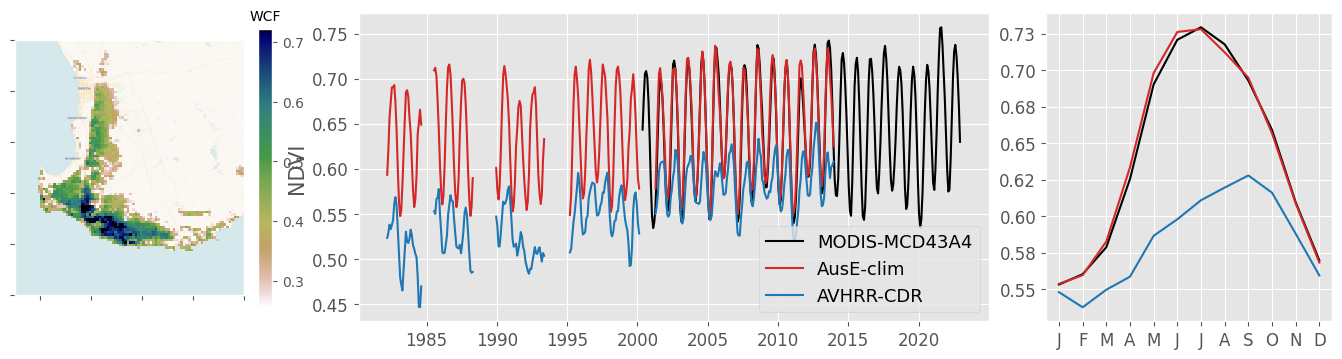

In [7]:
mosiac = [
    ["A", "B", "B", "C"],
]

fig, ax = plt.subplot_mosaic(mosiac, figsize=(17,4))

im = trees.where(trees>0.25).sel(longitude=lon, latitude=lat).plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 
cbar = plt.colorbar(im, ax=ax['A'], shrink=0.9)
cbar.ax.set_title('WCF', fontsize=10)
ax['A'].set_yticklabels([])
ax['A'].set_xticklabels([])
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)


modis.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='MODIS-MCD43A4', color='black')
merge.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='AusE-clim', color='tab:red')
avhrr.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=roll).mean().plot(ax=ax["B"], label='AVHRR-CDR', color='tab:blue')


ax["B"].grid(True)
ax["B"].legend(fontsize=13, loc='best')
ax["B"].set_title(None)
ax["B"].set_ylabel('NDVI', fontsize=15)
ax["B"].set_xlabel(None)
# ax["B"].set_ylim(0.425, 0.775)
ax['B'].tick_params(axis='y', labelsize=12)
ax['B'].tick_params(axis='x', labelsize=12)

modis.sel(longitude=lon, latitude=lat).sel(time=slice('2001','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='MODIS-MCD43A4', color='black')
merge.sel(longitude=lon, latitude=lat).sel(time=slice('2001','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='AusE-clim', color='tab:red')
avhrr.sel(longitude=lon, latitude=lat).sel(time=slice('2001','2013')).groupby('time.month').mean().mean(['latitude','longitude']).plot(ax=ax["C"], label='AVHRR-CDR', color='tab:blue')

# ax["C"].legend(fontsize=10)
ax["C"].set_title(None)
ax["C"].set_ylabel(None)
ax["C"].set_xlabel(None)
# ax["C"].set_ylim(0.425, 0.775)
ax['C'].tick_params(axis='y', labelsize=12)
ax['C'].set_yticklabels(['{:3.2f}'.format(x) for x in ax['C'].get_yticks()])
ax["C"].set_xticks(range(1,13))
ax["C"].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"],fontsize=12);

plt.tight_layout();
fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/"+plotname+"_trees_timeseries.png",
            bbox_inches='tight', dpi=300);